In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
 
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"] = 150

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path_colab = "/content/boston.csv"
df = pd.read_csv(path_colab)
df.drop(columns = "Unnamed: 0", inplace = True)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Al aplicar el método DataFrame.info() observamos que no hay datos nulos, por lo que no será necesario aplicar posteriormente pd.Series.dropna().

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Posteriormente, creamos la matriz de entrenamiento y los modelos asociados:

1. Model1 = con cálculo de intercepto y normalización de datos
2. Model2 = sin cálculo de intercepto, sin normalización de datos

In [4]:
y_vec = df.loc[:, "medv"]
X_mat = df.drop(["medv"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size = 0.33, random_state = 482)

In [5]:
model1 = linear_model.LinearRegression(fit_intercept = True, normalize = True).fit(X_train, y_train)
model1_yhat = model1.predict(X_test)

model2 = linear_model.LinearRegression(fit_intercept = False, normalize = False).fit(X_train, y_train)
model2_yhat = model2.predict(X_test)

In [6]:
"""
----
Función report_scores:
----
Argumentos:
1. yhat_vec: vector resultante de la predicción con el método model.predict de sklearn.model_selection: train_test_split
2. ytest_vec: vector de prueba, obtenido del dataframe en análisis, que corresponde a los resultados de la variable dependiente de la cual se desea predecir valores.
----

La fórmula utiliza ambos parámetros para calcular el MSE (Promedio del Error Cuadrático) y el indicador R^2 (o R-cuadrado), ambos indicadores útiles para comparar un modelo con otro.
En general, el indicador R-cuadrado es más fidedigno para evaluar la capacidad predictiva de un modelo, buscando evaluar qué modelo tiene un indicador menor. Por otro lado, el indicador
MSE analiza el error promedio de la función en relación a la función calculada, pero no siempre un MSE menor implica un mejor ajuste.

"""

def report_scores(yhat_vec, ytest_vec):
  
  mse = mean_squared_error(ytest_vec, yhat_vec).round(0)
  r2 = r2_score(ytest_vec, yhat_vec).round(2)
  
  return print("El modelo tiene los siguientes indicadores:\nError Cuadrático es:", mse, ", e indicador R2 es:", r2)

report_scores(model1_yhat, y_test)

El modelo tiene los siguientes indicadores:
Error Cuadrático es: 21.0 , e indicador R2 es: 0.72


In [7]:
report_scores(model2_yhat, y_test)

El modelo tiene los siguientes indicadores:
Error Cuadrático es: 24.0 , e indicador R2 es: 0.68


Dados los datos presentados, el modelo 2 (sin intercepto ni datos normalizados) tiene una capacidad predictiva ligeramente mayor que el modelo 1 con un R2 = 0.68, en comparación el R2 = 0.72 del modelo 1.

In [8]:
"""
----
Función fetch_features:
----
Argumentos:
1. dataframe: tabla de datos a analizar. Objeto debe ser del tipo pd.DataFrame.
2. obj_vec: vector de la variable dependiente, de la cual se desea predecir valores.

Nota: por defecto la segunda variable será medv, la indicada en el caso del presente enunciado.

----

La fórmula realiza lo siguiente:
1. Cambio de variable de dataframe
2. Extraer las columnas del dataframe
3. Crear listas vacías para almacenar: las variables a comparar (attr_name), resultados del Pearson Correlation Coefficient o PCC (pearson_r), resultados del PCC en valor absoluto (abs_pearson_r)
4. Se itera en las columnas del dataframe para obtener el nombre de la variable, el PCC y valor absoluto de PCC, y agregarlos a cada lista
5. Se crea dataframe con columnas formadas por las listas ya creadas (features)
6. Se indica como index el campo el atributo, y los valores son ordenados según abs_pearson_r, sobreescribiendo el dataframe del paso 5 (se guarda con valores ordenados, con el parámetro inplace = True del método DataFrame.sort_values)
7. Función retorna el dataframe features.

"""

def fetch_features(dataframe, obj_vec = "medv"):
  
  tmp = dataframe
  cols = tmp.columns
  attr_name = []
  pearson_r = []
  abs_pearson_r = []

  for col in cols:
    if col != obj_vec:
      attr_name.append(col)
      pearson_r.append(tmp[col].corr(tmp[obj_vec]))
      abs_pearson_r.append(abs(tmp[col].corr(tmp[obj_vec])))

  features = pd.DataFrame({
      "attribute": attr_name,
      "corr": pearson_r,
      "abs_corr": abs_pearson_r
  })

  features = features.set_index("attribute")
  features.sort_values(by = "abs_corr", ascending = False, inplace = True)

  return features

fetch_features(df, "medv")

,corr,abs_corr
attribute,,
lstat,-0.737663,0.737663
rm,0.695360,0.695360
ptratio,-0.507787,0.507787
indus,-0.483725,0.483725
tax,-0.468536,0.468536
nox,-0.427321,0.427321
crim,-0.388305,0.388305
rad,-0.381626,0.381626
age,-0.376955,0.376955


Las variables con mayor correlación con Medv son:
1. lstat
2. rm
3. ptratio
4. indus
5. tax
6. nox

Que serán utilizadas para la creación de un nuevo modelo.

In [9]:
y_vec3 = df.loc[:, "medv"]
X_mat3 = df.drop(["crim", "zn", "chas", "age", "dis", "rad", "black", "medv"], axis = 1)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_mat3, y_vec3, test_size = 0.3, random_state = 482)
model3 = linear_model.LinearRegression(fit_intercept = True, normalize = True).fit(X_train3, y_train3)
model3_yhat = model3.predict(X_test3)

m3_mse = mean_squared_error(y_test3, model3_yhat).round(0)
m3_r2 = r2_score(y_test3, model3_yhat).round(2)

print("Modelo para predicción de variable Balance en dataframe df_bin con todas las variables como regresor:\nError Cuadrático es:", m3_mse, ", e indicador R2 es:", m3_r2)

Modelo para predicción de variable Balance en dataframe df_bin con todas las variables como regresor:
Error Cuadrático es: 21.0 , e indicador R2 es: 0.7


Se observa que el modelo 3 tiene prácticamente el mismo comportamiento que los modelos 1 y 2, a pesar de haber eliminado variables. Es posible que los modelos 1 y 2 hayan dado una baja ponderación a las variables eliminadas en el modelo 3, no influyendo significativamente en su capacidad predictiva, que es prácticamente la misma.

Antes de incorporar el array en el modelo, lo reordenaremos para que se acomode al dataframe, que está en el orden siguiente:

In [10]:
X_mat3.columns

Index(['indus', 'nox', 'rm', 'tax', 'ptratio', 'lstat'], dtype='object')

En cambio, al revisar las medidas descriptivas de df_bin corroborar el orden de los nuevos arrays, descubrimos que best_neigbor y worst_neigbor tienen un orden diferente:

["lstat", "ptratio", "rm", "indus", "tax", "nox"]

Ahora bien, al comparar estos datos con los mínimos y máximos de nuestro dataframe, estos arrays fueron hechos en base a tal información, utilizando los mínimos y máximos de cada variable.

Re-ordenaremos los arrays y posteriormente los introduciremos en el modelo para conocer qué valores de "medv" arrojan.

In [11]:
X_test_best = np.array([1.73, 22, 8.7, 0.46, 711, 0.38])
X_test_worst = np.array([37.9, 12.6, 3.5, 27.7, 187, 0.87])

#cambio de orden de variables

idx = [3, 5, 2, 4, 1, 0]
X_test_best = X_test_best[idx].reshape(1,-1)
X_test_worst = X_test_worst[idx].reshape(1,-1)

model3_yhat_best = model3.predict(X_test_best)
model3_yhat_worst = model3.predict(X_test_worst)

print("La predicción de medv con el vector de prueba best_neigbor es:", model3_yhat_best, "\n---------------------------\n","La predicción de medv con el vector de prueba worst_neigbor es:", model3_yhat_worst)

La predicción de medv con el vector de prueba best_neigbor es: [35.15831437] 
---------------------------
 La predicción de medv con el vector de prueba worst_neigbor es: [1.89683502]


Finalmente, los vectores insertados arrojan valores extremos: en el caso de best_neigbor el valor sería un outlier (tal como se observa en el boxplot siguiente), y en el caso de worst_neigobr sería un valor de la cola del rango 0%-25%. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


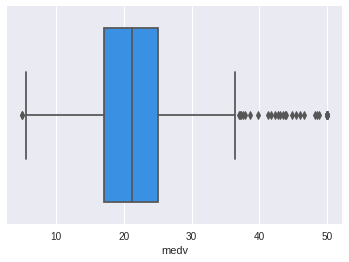

In [12]:
sns.boxplot(y_vec3, color = "dodgerblue")

1. Corregir con shuffle!!, si no el dataset puede estar no aleatorio :(, puede ocurrir batch (conjunto ya viene con separaciones internas que pueden sesgar el modelo)
2. df.corr para fetch_features, podría ser más corta en vdd


In [14]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
list(df.columns)

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']